# Blackjack TD Evaluation
## Rule and Policy for Blackjack
![rule_and_policy](../images/lecture_2/blackjack.png)

## Gymnasium

Blackjack is a card game where the goal is to beat the dealer by obtaining cards
that sum to closer to 21 (without going over 21) than the dealers cards.

### Env Description
The game starts with the dealer having one face up and one face down card,
while the player has two face up cards. All cards are drawn from an infinite deck
(i.e. with replacement).

The card values are:
- Face cards (Jack, Queen, King) have a point value of 10.
- Aces can either count as 11 (called a 'usable ace') or 1.
- Numerical cards (2-9) have a value equal to their number.

The player has the sum of cards held. The player can request
additional cards (hit) until they decide to stop (stick) or exceed 21 (bust,
immediate loss).

After the player sticks, the dealer reveals their facedown card, and draws cards
until their sum is 17 or greater. If the dealer goes bust, the player wins.

If neither the player nor the dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.

This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto [<a href="#blackjack_ref">1</a>].

### Action Space
The action shape is `(1,)` in the range `{0, 1}` indicating
whether to stick or hit.

- 0: Stick
- 1: Hit

### Observation Space
The observation consists of a 3-tuple containing: the player's current sum,
the value of the dealer's one showing card (1-10 where 1 is ace),
and whether the player holds a usable ace (0 or 1).

The observation is returned as `(int(), int(), int())`.

### Starting State
The starting state is initialised in the following range.

| Observation               | Min  | Max  |
|---------------------------|------|------|
| Player current sum        |  4   |  12  |
| Dealer showing card value |  2   |  11  |
| Usable Ace                |  0   |  1   |

### Rewards
- win game: +1
- lose game: -1
- draw game: 0
- win game with natural blackjack:
+1.5 (if <a href="#nat">natural</a> is True)
+1 (if <a href="#nat">natural</a> is False)

### Episode End
The episode ends if the following happens:

- Termination:
1. The player hits and the sum of hand exceeds 21.
2. The player sticks.

An ace will always be counted as usable (11) unless it busts the player.

### Information

No additional information is returned.

### Arguments

```python
import gymnasium as gym
gym.make('Blackjack-v1', natural=False, sab=False)
```

<a id="nat"></a>`natural=False`: Whether to give an additional reward for
starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

<a id="sab"></a>`sab=False`: Whether to follow the exact rules outlined in the book by
Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
If the player achieves a natural blackjack and the dealer does not, the player
will win (i.e. get a reward of +1). The reverse rule does not apply.
If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

### References
<a id="blackjack_ref"></a>[1] R. Sutton and A. Barto, “Reinforcement Learning:
An Introduction” 2020. [Online]. Available: [http://www.incompleteideas.net/book/RLbook2020.pdf](http://www.incompleteideas.net/book/RLbook2020.pdf)

### Version History
* v1: Fix the natural handling in Blackjack
* v0: Initial version release

## TD algorithm
![td_prediction](../images/lecture_2/td_prediction.png)

## Import Env

In [26]:
import gymnasium as gym
for k,v in gym.envs.registry.items():
    print(str(k)+"\t"+str(v))

CartPole-v0	EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1	EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0	EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.

In [27]:
from gymnasium.envs.toy_text.blackjack import BlackjackEnv
env=gym.make("Blackjack-v1")

In [28]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [29]:
env.action_space.n

2

## Set Policy

In [30]:
def get_action(state: env.observation_space):
    """0 is stick, 1 is hit"""
    player_sum, dealer_sum, usable_ace = state
    return 1 if player_sum < 20 else 0

## Run Simulation

In [31]:
from collections import defaultdict


def td_policy_evaluation(env: gym.Env, num_episode: int, alpha: float = 0.1, gamma: float = 0.9):
    q = defaultdict(float)
    for _ in range(num_episode):
        state = env.reset()[0]
        is_terminated = False
        while not is_terminated:
            action = get_action(state)
            next_state, reward, is_terminated, is_truncated, info = env.step(
                action)
            q[state] += alpha*(reward+gamma*q[next_state]-q[state])
            state = next_state
    return q


In [32]:
q=td_policy_evaluation(env,int(1e5))

In [33]:
q

defaultdict(float,
            {(14, 9, 0): 1.2153961541558636,
             (24, 9, 0): 0.0,
             (20, 5, 0): 7.184883111495354,
             (20, 10, 0): 3.971962732335003,
             (14, 7, 0): 0.9075850731087098,
             (24, 7, 0): 0.0,
             (12, 5, 0): 1.157508362014036,
             (18, 5, 0): 0.2362116505796408,
             (28, 5, 0): 0.0,
             (10, 2, 0): 2.5273852797270338,
             (20, 2, 0): 6.045473456208666,
             (20, 9, 0): 7.846942735126986,
             (9, 10, 0): 1.273080114956922,
             (15, 10, 0): 0.6431287265173393,
             (22, 10, 0): 0.0,
             (15, 8, 0): 0.166639405745095,
             (23, 8, 0): 0.0,
             (18, 4, 0): 0.4893596396158957,
             (20, 4, 0): 6.290523104623518,
             (12, 4, 0): 1.8133648472606803,
             (16, 4, 0): 1.896560792064996,
             (22, 4, 0): 0.0,
             (21, 8, 1): 9.775681791275318,
             (20, 3, 0): 6.8173679458676455

In [34]:
import matplotlib.pyplot as plt
from typing import Dict
from typing import Tuple
import numpy as np


def plot_evaluation(v: Dict[Tuple[int, int, int], float], with_ace: int):
    ks = np.asarray([k for k in v.keys()])
    x_min = np.min(ks[:, 0])
    x_max = np.max(ks[:, 0])
    y_min = np.min(ks[:, 1])
    y_max = np.max(ks[:, 1])
    x_range = np.arange(x_min, x_max+1)
    y_range = np.arange(y_min, y_max+1)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z = np.apply_along_axis(
        lambda x: v[(x[0], x[1], with_ace)], 2, np.dstack([x_grid, y_grid]))
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    ax.plot_surface(x_grid, y_grid, z)

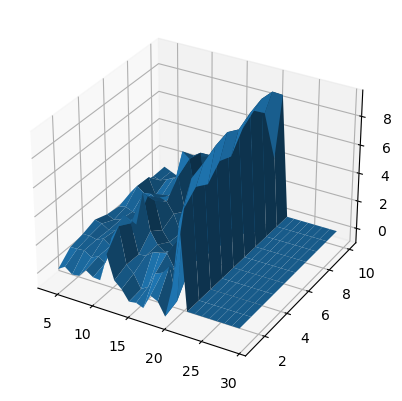

In [35]:
q_noace=dict(filter(lambda x:x[0][2]==0,q.items()))
plot_evaluation(q_noace,0)

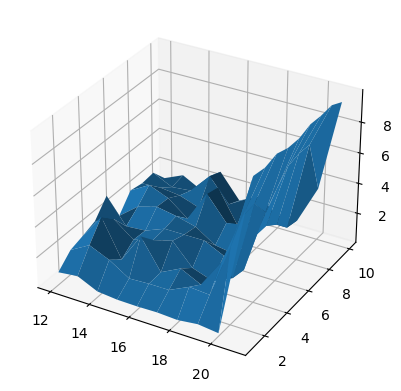

In [36]:
q_ace=dict(filter(lambda x:x[0][2]==1,q.items()))
plot_evaluation(q_ace,1)